In [16]:
# import os
# from pathlib import Path
# import nibabel as nib
# import cv2
# import numpy as np

# def add_holes(image, max_holes=10, max_diameter=30):
#     """
#     Add random circular holes to the image
#     Args:
#         image: Input image (grayscale)
#         max_holes: Maximum number of holes to add
#         max_diameter: Maximum diameter of holes in pixels
#     Returns:
#         Distorted image with holes
#     """
#     height, width = image.shape
#     distorted = image.copy()
    
#     # Random number of holes (1 to max_holes)
#     n_holes = np.random.randint(1, max_holes + 1)
    
#     for _ in range(n_holes):
#         # Random diameter (5 to max_diameter)
#         diameter = np.random.randint(5, max_diameter + 1)
#         radius = diameter // 2
        
#         # Random position (ensuring hole is within the lung area)
#         # Find non-zero pixels (lung area)
#         lung_pixels = np.where(image > 20)  # threshold to find lung area
#         if len(lung_pixels[0]) == 0:  # Skip if no lung area found
#             continue
            
#         # Randomly select a point within the lung area
#         idx = np.random.randint(0, len(lung_pixels[0]))
#         center_y = lung_pixels[0][idx]
#         center_x = lung_pixels[1][idx]
        
#         # Create circular mask
#         y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
#         mask = x*x + y*y <= radius*radius
        
#         # Apply the hole (set pixels to 0)
#         y_min, y_max = max(0, center_y-radius), min(height, center_y+radius+1)
#         x_min, x_max = max(0, center_x-radius), min(width, center_x+radius+1)
        
#         mask_height = y_max - y_min
#         mask_width = x_max - x_min
#         mask = mask[:mask_height, :mask_width]
        
#         distorted[y_min:y_max, x_min:x_max][mask] = 0
        
#     return distorted

# def generate_training_set(input_dir, output_dir, create_pairs=True):
#     if not os.path.exists(input_dir):
#         raise FileNotFoundError(f"Directory {input_dir} not found")
    
#     # Create or clean output directories
#     clean_dir = os.path.join(output_dir, 'clean')
#     noisy_dir = os.path.join(output_dir, 'noisy')
#     os.makedirs(clean_dir, exist_ok=True)
#     os.makedirs(noisy_dir, exist_ok=True)
    
#     # Clean directories
#     for dir_path in [clean_dir, noisy_dir]:
#         for file in Path(dir_path).glob('*'):
#             try:
#                 file.unlink()
#             except Exception as e:
#                 print(f"Error removing {file}: {e}")
    
#     slices = []
#     slice_count = 0

#     for file_path in Path(input_dir).glob('*'):
#         try:
#             ct_img = nib.load(str(file_path))
#             ct_data = ct_img.get_fdata()
#             for i in range(ct_data.shape[2]):
#                 slice_img = ct_data[:, :, i]
#                 slice_img = cv2.resize(slice_img, (256, 256))
#                 slices.append(slice_img)
#         except Exception as e:
#             print(f"Error processing {file_path}: {e}")
#             continue
    
#     # Save clean and noisy versions
#     for slice_idx, slice_img in enumerate(slices):
#         try:
#             # Normalize original image
#             normalized = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX)
#             clean_img = normalized.astype('uint8')
            
#             # Create and normalize noisy version
#             noisy_img = add_holes(clean_img)
            
#             # Save both versions
#             clean_path = os.path.join(clean_dir, f'slice_{slice_idx:04d}.png')
#             noisy_path = os.path.join(noisy_dir, f'slice_{slice_idx:04d}.png')
            
#             cv2.imwrite(clean_path, clean_img)
#             cv2.imwrite(noisy_path, noisy_img)
#             slice_count += 1
            
#         except Exception as e:
#             print(f"Error saving slice {slice_idx}: {e}")
#             continue
    
#     print(f"Saved {slice_count} pairs of clean and noisy images to {output_dir}")
#     return slices

In [8]:
import numpy as np
import cv2
import os
from pathlib import Path

def create_ellipse_image(size=(256, 256), short_axis_min=100, long_axis_min=250, ratio=3):
    """
    Create a synthetic ellipse image.
    Args:
        size: Size of the output image (height, width).
        short_axis_min: Minimum length of the short axis.
        long_axis_min: Minimum length of the long axis.
        ratio: Maximum ratio of long axis to short axis.
    Returns:
        An image with a drawn ellipse.
    """
    # Ensure that the minimum lengths are valid for the given size
    if short_axis_min >= size[0] or long_axis_min >= size[1]:
        raise ValueError("Minimum axis lengths must be less than the image size.")

    # Randomly generate axes lengths
    short_axis = np.random.randint(short_axis_min, size[1])
    long_axis = np.random.randint(long_axis_min, size[0])

    # Ensure the ratio constraint
    if long_axis / short_axis > ratio:
        long_axis = int(short_axis * ratio)

    # Create a blank image
    image = np.zeros(size, dtype=np.uint8)

    # Calculate the center of the ellipse
    center = (size[1] // 2, size[0] // 2)

    # Draw the ellipse
    cv2.ellipse(image, center, (long_axis // 2, short_axis // 2), 0, 0, 360, 255, -1)

    return image

def add_holes(image, max_holes=10, max_diameter=30):
    """
    Add random circular holes to the image.
    Args:
        image: Input image (grayscale).
        max_holes: Maximum number of holes to add.
        max_diameter: Maximum diameter of holes in pixels.
    Returns:
        Distorted image with holes.
    """
    height, width = image.shape
    distorted = image.copy()

    # Random number of holes (1 to max_holes)
    n_holes = np.random.randint(1, max_holes + 1)

    for _ in range(n_holes):
        # Random diameter (5 to max_diameter)
        diameter = np.random.randint(5, max_diameter + 1)
        radius = diameter // 2

        # Random position (ensuring hole is within the image)
        center_y = np.random.randint(radius, height - radius)
        center_x = np.random.randint(radius, width - radius)

        # Create circular mask
        y, x = np.ogrid[-radius:radius + 1, -radius:radius + 1]
        mask = x * x + y * y <= radius * radius

        # Apply the hole (set pixels to 0)
        y_min, y_max = max(0, center_y - radius), min(height, center_y + radius + 1)
        x_min, x_max = max(0, center_x - radius), min(width, center_x + radius + 1)

        mask_height = y_max - y_min
        mask_width = x_max - x_min
        mask = mask[:mask_height, :mask_width]

        distorted[y_min:y_max, x_min:x_max][mask] = 0

    return distorted

def generate_training_set(output_dir, num_images=100):
    # Create or clean output directories
    clean_dir = os.path.join(output_dir, 'clean')
    noisy_dir = os.path.join(output_dir, 'noisy')
    os.makedirs(clean_dir, exist_ok=True)
    os.makedirs(noisy_dir, exist_ok=True)

    # Clean directories
    for dir_path in [clean_dir, noisy_dir]:
        for file in Path(dir_path).glob('*'):
            try:
                file.unlink()
            except Exception as e:
                print(f"Error removing {file}: {e}")

    slice_count = 0

    for slice_idx in range(num_images):
        try:
            # Create a clean ellipse image
            clean_img = create_ellipse_image()

            # Create and normalize noisy version
            noisy_img = add_holes(clean_img)

            # Save both versions
            clean_path = os.path.join(clean_dir, f'slice_{slice_idx:04d}.png')
            noisy_path = os.path.join(noisy_dir, f'slice_{slice_idx:04d}.png')

            cv2.imwrite(clean_path, clean_img)
            cv2.imwrite(noisy_path, noisy_img)
            slice_count += 1

        except Exception as e:
            print(f"Error saving slice {slice_idx}: {e}")
            continue

    print(f"Saved {slice_count} pairs of clean and noisy images to {output_dir}")
    return slice_count


In [9]:
output_dir = "trainingData"
num_images = 100 
generate_training_set(output_dir, num_images)

Saved 100 pairs of clean and noisy images to trainingData


100

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2

# Define the Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use Sigmoid for binary output
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class DenoisingDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir):
        """
        Args:
            clean_dir: Directory with original images
            noisy_dir: Directory with noisy images
        """
        self.clean_dir = Path(clean_dir)
        self.noisy_dir = Path(noisy_dir)
        self.image_files = sorted(list(self.clean_dir.glob('*.png')))  # Get all PNG files
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get clean image path and construct corresponding noisy image path
        clean_path = self.image_files[idx]
        noisy_path = self.noisy_dir / clean_path.name
        
        # Load images
        clean_img = cv2.imread(str(clean_path), cv2.IMREAD_GRAYSCALE)
        noisy_img = cv2.imread(str(noisy_path), cv2.IMREAD_GRAYSCALE)
        
        # Normalize to [0,1]
        clean_img = clean_img.astype(np.float32) / 255.0
        noisy_img = noisy_img.astype(np.float32) / 255.0
        
        # Add channel dimension
        clean_img = np.expand_dims(clean_img, axis=0)
        noisy_img = np.expand_dims(noisy_img, axis=0)
        
        return torch.FloatTensor(noisy_img), torch.FloatTensor(clean_img)

def train_autoencoder(clean_dir, noisy_dir, num_epochs=100, batch_size=32):
    # Try to load existing model
    try:
        model = torch.load('model.pth')
        print("Loaded existing model")
    except (FileNotFoundError, IOError):
        print("No existing model found, training new model")
        model = DenoisingAutoencoder()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dataset and dataloader
    dataset = DenoisingDataset(clean_dir, noisy_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (noisy, clean) in enumerate(dataloader):
            # pritndata
            noisy, clean = noisy.to(device), clean.to(device)
            
            # Forward pass
            output = model(noisy)
            loss = criterion(output, clean)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx+1}/{len(dataloader)}], '
                      f'Loss: {loss.item():.6f}')
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')
        
        # Save model periodically
        if (epoch + 1) % 10 == 0:
            torch.save(model, 'model.pth')
            print(f'Model saved at epoch {epoch+1}')
    
    # Save final model
    torch.save(model, 'model.pth')
    print('Training finished!')
    return model

# Function to test the model on a single image
def denoise_image(model, image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=(0, 1))  # Add batch and channel dimensions
    img_tensor = torch.FloatTensor(img).to(device)
    
    with torch.no_grad():
        denoised = model(img_tensor)
    
    # Convert back to image
    denoised = denoised.cpu().numpy()[0, 0]
    denoised = (denoised * 255).astype(np.uint8)
    
    return denoised


In [ ]:
num_epochs = 30
clean_dir = "trainingData/clean"
noisy_dir = "trainingData/noisy"
model = train_autoencoder(clean_dir, noisy_dir, num_epochs=num_epochs, batch_size=32)


C:\Users\krzys\AppData\Local\Temp\ipykernel_10212\2447680117.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')


Text(0.5, 1.0, 'Reference Clean Image')

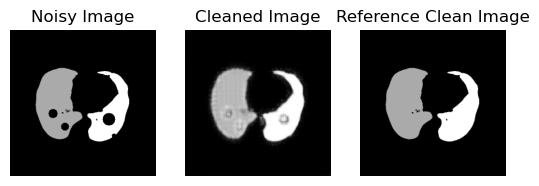

In [37]:
import matplotlib.pyplot as plt

model = torch.load('model.pth')
ref_path = 'trainingData/clean/slice_0066.png'
noisy_path = 'trainingData/noisy/slice_0066.png'

cleaned_img = denoise_image(model, noisy_path)
ref_img = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
noisy_img = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)

f, ax = plt.subplots(1, 3)
ax[0].imshow(noisy_img, 'gray')
ax[0].axis('off')
ax[0].set_title("Noisy Image")
ax[1].imshow(cleaned_img, 'gray')
ax[1].axis('off')
ax[1].set_title("Cleaned Image")
ax[2].imshow(ref_img, 'gray')
ax[2].axis('off')
ax[2].set_title("Reference Clean Image")

In [1]:
import cv2
ref_path = 'trainingData/clean/slice_0066.png'

ref_img = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
print(ref_img.shape)

(256, 256)
